# SMER Visual Module Demonstration

This notebook demonstrates the functionality of the `smer_visual.py` module, which provides tools for generating image descriptions, embeddings, and analyzing feature importance using logistic regression.

---

## 1. Setup

First, we import the necessary libraries and set up the environment.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from smer import (
    image_descriptions,
    embed_descriptions,
    classify_lr,
    plot_important_words,
    plot_aopc,
    aggregate_embeddings,
    save_bounding_box_images
)

# Set paths and parameters
data_folder = "data"
model_path = "sentence-transformers/all-MiniLM-L6-v2"
api_key = "your_openai_api_key"  # Replace with your OpenAI API key
embedding_model = "text-embedding-ada-002"
user_prompt = "Describe this image in 7 words."

---

## 2. Generate Image Descriptions

We use the `image_description` function to generate descriptions for images in the specified folder.

In [2]:
# Generate descriptions using a local model
results = image_descriptions(model="unsloth/Llama-3.2-11B-Vision-Instruct", data_folder="data") 

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# Alternatively, generate descriptions using OpenAI API
results = image_description(model='gpt-4o-mini', data_folder=data_folder, api_key=api_key, user_prompt=user_prompt)

In [4]:
results

{'data/vase/n04522168_494.JPEG': {'label': 'vase',
  'description': 'The image depicts a vase, with a distinctive rounded base.',
  'error': None},
 'data/vase/n04522168_123.JPEG': {'label': 'vase',
  'description': 'A vase with a unique ceramic design.',
  'error': None},
 'data/vase/n04522168_529.JPEG': {'label': 'vase',
  'description': 'A vase, plant, and tablecloth are displayed.',
  'error': None},
 'data/vase/n04522168_154.JPEG': {'label': 'vase',
  'description': 'The image features an Egyptian vase with handles.',
  'error': None},
 'data/vase/n04522168_483.JPEG': {'label': 'vase',
  'description': 'A decorative glass vessel with colorful handles.',
  'error': None},
 'data/vase/n04522168_390.JPEG': {'label': 'vase',
  'description': 'The image features a brown vase with intricate designs.',
  'error': None},
 'data/vase/n04522168_100.JPEG': {'label': 'vase',
  'description': 'An old vase with handles and blue patterns.',
  'error': None},
 'data/vase/n04522168_251.JPEG': {'la

---

## 3. Generate Embeddings for Descriptions

Next, we generate embeddings for the descriptions using the `get_description_embeddings` function.

In [5]:
# Generate embeddings for the descriptions locally
df_embeddings = embed_descriptions(results, embedding_model = "sentence-transformers/all-MiniLM-L6-v2")

# Display the embeddings DataFrame
print(df_embeddings.head())

                          image  \
0  data/vase/n04522168_494.JPEG   
1  data/vase/n04522168_123.JPEG   
2  data/vase/n04522168_529.JPEG   
3  data/vase/n04522168_154.JPEG   
4  data/vase/n04522168_483.JPEG   

                                         description  \
0  The image depicts a vase, with a distinctive r...   
1               A vase with a unique ceramic design.   
2       A vase, plant, and tablecloth are displayed.   
3  The image features an Egyptian vase with handles.   
4   A decorative glass vessel with colorful handles.   

                                           embedding label  
0  [[-0.19027631, -0.02671379, -0.08945237, 0.149...  vase  
1  [[-0.16147648, -0.076564945, -0.04694235, 0.21...  vase  
2  [[-0.16147648, -0.076564945, -0.04694235, 0.21...  vase  
3  [[-0.19027631, -0.02671379, -0.08945237, 0.149...  vase  
4  [[-0.16147648, -0.076564945, -0.04694235, 0.21...  vase  


In [6]:
# Generate embeddings using OpenAI API
df_embeddings = embed_descriptions(results, embedding_model=embedding_model, api_key=api_key)

---

## 4. Train Logistic Regression Model

We train a logistic regression model using the embeddings.

In [7]:
# aggregate embeddings by averaging
df_embeddings['aggregated_embedding'] = df_embeddings['embedding'].apply(aggregate_embeddings)
df_embeddings.head()

,image,description,embedding,label,aggregated_embedding
0,data/vase/n04522168_494.JPEG,"The image depicts a vase, with a distinctive r...","[[-0.19027631, -0.02671379, -0.08945237, 0.149...",vase,"[0.01670754, -0.039057996, 0.04937666, -0.0922..."
1,data/vase/n04522168_123.JPEG,A vase with a unique ceramic design.,"[[-0.16147648, -0.076564945, -0.04694235, 0.21...",vase,"[-0.059109304, -0.0036887506, 0.045356043, -0...."
2,data/vase/n04522168_529.JPEG,"A vase, plant, and tablecloth are displayed.","[[-0.16147648, -0.076564945, -0.04694235, 0.21...",vase,"[-0.13349508, 0.064699225, 0.119369335, -0.030..."
3,data/vase/n04522168_154.JPEG,The image features an Egyptian vase with handles.,"[[-0.19027631, -0.02671379, -0.08945237, 0.149...",vase,"[-0.026166521, 0.04031609, 0.120682865, 0.0346..."
4,data/vase/n04522168_483.JPEG,A decorative glass vessel with colorful handles.,"[[-0.16147648, -0.076564945, -0.04694235, 0.21...",vase,"[-0.0034143552, 0.026342185, 0.13261056, 0.104..."


In [8]:
X = np.stack(df_embeddings['aggregated_embedding'].values)
y = df_embeddings['label']
logreg_model = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [9]:
from sklearn.metrics import accuracy_score
y_pred = logreg_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

1.0


---

## 5. Analyze Feature Importance

Using the `classify_with_logreg` function, we analyze the importance of individual words in the descriptions.

In [10]:
# Analyze feature importance
aopc_df, updated_dataset = classify_lr(
    dataset=df_embeddings,
    X_train=X_train,
    logreg_model=logreg_model
)

# Display the updated dataset
print(updated_dataset.head())

                          image  \
0  data/vase/n04522168_494.JPEG   
1  data/vase/n04522168_123.JPEG   
2  data/vase/n04522168_529.JPEG   
3  data/vase/n04522168_154.JPEG   
4  data/vase/n04522168_483.JPEG   

                                         description  \
0  The image depicts a vase, with a distinctive r...   
1               A vase with a unique ceramic design.   
2       A vase, plant, and tablecloth are displayed.   
3  The image features an Egyptian vase with handles.   
4   A decorative glass vessel with colorful handles.   

                                           embedding label  \
0  [[-0.19027631, -0.02671379, -0.08945237, 0.149...  vase   
1  [[-0.16147648, -0.076564945, -0.04694235, 0.21...  vase   
2  [[-0.16147648, -0.076564945, -0.04694235, 0.21...  vase   
3  [[-0.19027631, -0.02671379, -0.08945237, 0.149...  vase   
4  [[-0.16147648, -0.076564945, -0.04694235, 0.21...  vase   

                                aggregated_embedding  \
0  [0.01670754, -0.0390

---

## 6. Visualize Important Words

We use the `plot_important_words` function to visualize the top 10 most important words across images.

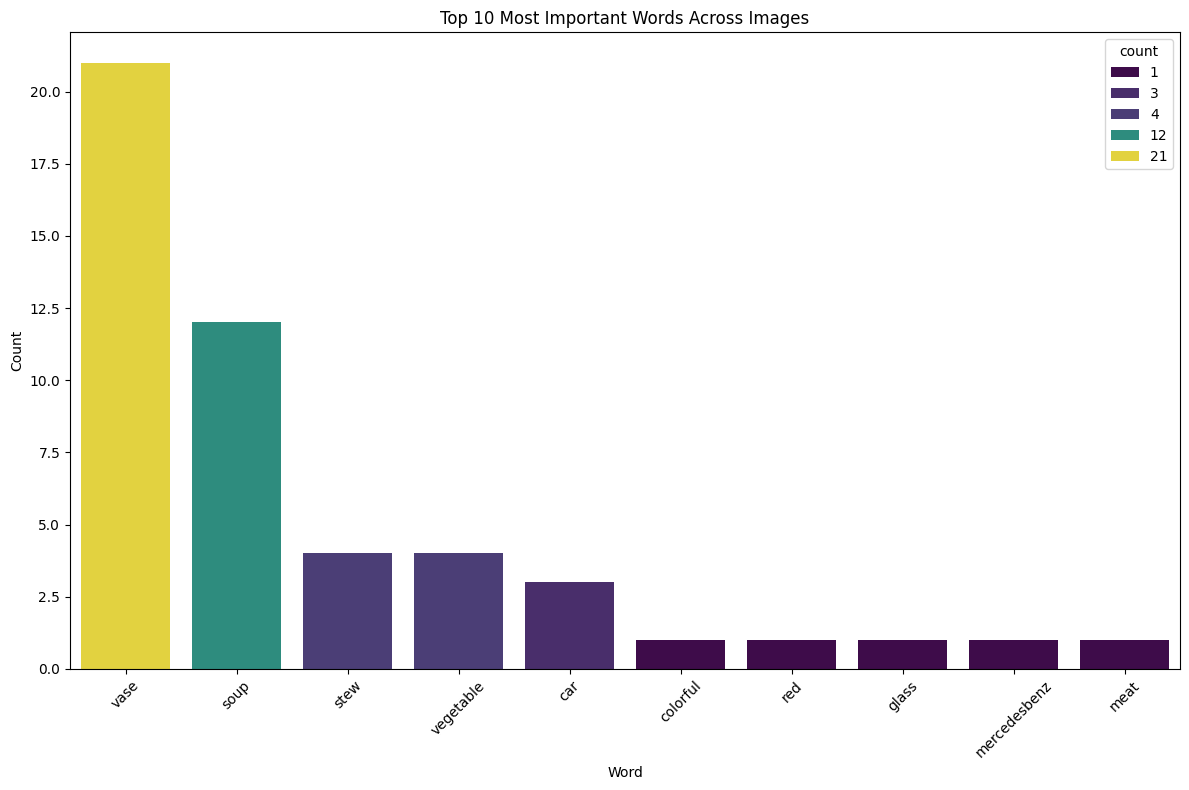

In [11]:
# Plot important words
top_words_df = plot_important_words(updated_dataset)

---

## 7. Compare AOPC Scores

Finally, we compare AOPC scores for SMER and LIME importance scores using the `plot_aopc` function.

Computing LIME importances: 100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


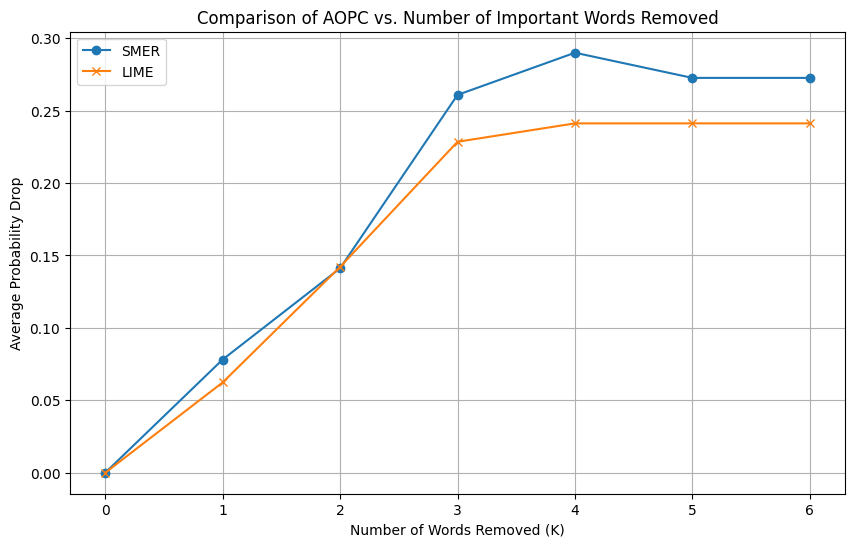

In [12]:
# Plot AOPC scores
plot_aopc(aopc_df, logreg_model, max_k=6)

### 8. Obtain bounding boxes of the most important objects
We use the grounding-dino for one-shot object detection.

In [13]:
save_bounding_box_images(
    input_path="data/",
    output_folder="output",
    df_top_words=top_words_df,
    model_id="IDEA-Research/grounding-dino-base",
    box_threshold = 0.5,
    text_threshold = 0.4
)

Error processing data/vase/n04522168_482.JPEG: Unsupported number of image dimensions: 2
Completed! Processed 60 images.
